In [73]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

# Load all Images and Captions

In [3]:
token_path = "../input/flickr-8k/Flickr8k.token.txt"
train_images_path = '../input/flickr-8k/Flickr_8k.trainImages.txt'
test_images_path = '../input/flickr-8k/Flickr_8k.testImages.txt'
images_path = '../input/flickr8k/Images/'
glove_path = '../input/glove6b/'

Make a dictionary of all images and their respective captions

In [4]:
doc = open(token_path,'r').read()

descriptions = dict()
for line in doc.split('\n'):
    contents = line.split("\t")
    if len(contents) > 1:
        img_id, caption = contents[0], contents[1]
        img_id = img_id[:-2]
        if img_id not in descriptions:
            descriptions[img_id] = list()
        descriptions[img_id].append(caption)
descriptions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Create a list of all train images and test images

In [5]:
train_img = []
test_img = []

doc = open(train_images_path,'r').read()
for line in doc.split('\n'):
    if len(line) > 1:
        train_img.append(line)
        
doc = open(test_images_path,'r').read()
for line in doc.split('\n'):
    if len(line) > 1:
        test_img.append(line)

print(train_img[:5])
print(test_img[:5])

['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg']
['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg', '1258913059_07c613f7ff.jpg', '241347760_d44c8d3a01.jpg']


# Captions preprocessing

Basic text cleaning to get rid of punctuation and conversion of descriptions to lowercase

In [6]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

Load a sample image and its captions

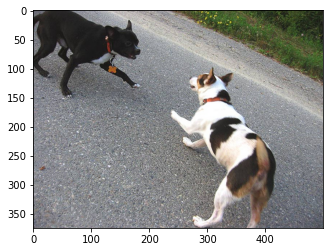

['a black dog and a spotted dog are fighting',
 'a black dog and a tricolored dog playing with each other on the road ',
 'a black dog and a white dog with brown spots are staring at each other in the street ',
 'two dogs of different breeds looking at each other on the road ',
 'two dogs on pavement moving toward each other ']

In [7]:
pic = '1001773457_577c3a7d70.jpg'
x = plt.imread(images_path + pic)
plt.imshow(x)
plt.show()
descriptions[pic]

# Build Vocabulary

Create a set of all unique words

In [8]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8828


# Add \<start> and \<end> to captions

Create dictionary of train and test images after appending \<start> and \<end> at the beginning and end of all captions

In [9]:
trainSet = set(train_img)

train_descriptions = dict()
test_descriptions = dict()

for img, captions in descriptions.items():
    if img in trainSet:
        if img not in train_descriptions:
            train_descriptions[img] = list()
        for caption in captions:
            desc = '<start> ' + caption + ' <end>'
            train_descriptions[img].append(desc)
    else:
        if img not in test_descriptions:
            test_descriptions[img] = list()
        for caption in captions:
            desc = '<start> ' + caption + ' <end>'
            test_descriptions[img].append(desc)

List of all the train captions

In [10]:
all_train_captions = []
for img, captions in train_descriptions.items():
    for caption in captions:
        all_train_captions.append(caption)

Words with frequency less than 10 are excluded

In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for caption in all_train_captions:
    nsents += 1
    for w in caption.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1660


Mapping between words and numbers

In [12]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

# Find length of longest caption

In [13]:
train_desc = list()
for key in train_descriptions.keys():
    [train_desc.append(d) for d in train_descriptions[key]]
lines = train_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


# GLoVe Embeddings

Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The basic premise behind Glove is that we can derive sematic relationships between words from the coouucrence matrix.

For our model, we will map all the 38-word long caption to a 200-dimension vector using Glove.

In [14]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [15]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Inception V-3

Transfer learning using Inception v-3 network which is pre-trained on the Image-Net dataset

In [16]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

2022-06-06 17:26:10.369877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 17:26:10.462093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 17:26:10.462908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 17:26:10.464543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

96124928/96112376 [==============================] - 1s 0us/step


In [17]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

Feature extraction using Inception v-3

In [18]:
encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(images_path + img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(images_path + img)

2022-06-06 17:26:16.398596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-06 17:26:18.298971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:
1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

In [19]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

# Model Training

In [20]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Function to train data in batches

In [22]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

Epoch 1/30
2000/2000 [==============================] - 227s 112ms/step - loss: 3.4958
Epoch 2/30
2000/2000 [==============================] - 222s 111ms/step - loss: 2.8532
Epoch 3/30
2000/2000 [==============================] - 222s 111ms/step - loss: 2.6633
Epoch 4/30
2000/2000 [==============================] - 222s 111ms/step - loss: 2.5517
Epoch 5/30
2000/2000 [==============================] - 219s 109ms/step - loss: 2.4745
Epoch 6/30
2000/2000 [==============================] - 216s 108ms/step - loss: 2.4147
Epoch 7/30
2000/2000 [==============================] - 214s 107ms/step - loss: 2.3669
Epoch 8/30
2000/2000 [==============================] - 213s 106ms/step - loss: 2.3258
Epoch 9/30
2000/2000 [==============================] - 213s 106ms/step - loss: 2.2939
Epoch 10/30
2000/2000 [==============================] - 218s 109ms/step - loss: 2.2643
Epoch 11/30
2000/2000 [==============================] - 215s 107ms/step - loss: 2.2408
Epoch 12/30
2000/2000 [==================

# Greedy Search and Beam Search

## Greedy Search

As the model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search.


In [38]:
def greedySearch(photo):
    in_text = '<start>'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break

    final = in_text.split()
    final = final[1:]
    final = ' '.join(final)
    return final

## Beam Search

Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘\<end>’ or reach the maximum caption length.

In [39]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Evaluation

## Test Samples

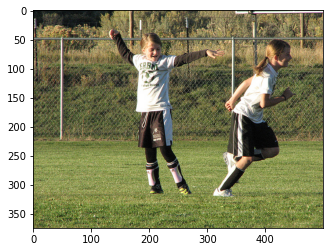

Greedy Search: a young boy wearing a red shirt and blue shorts is swinging a bat in a park
Beam Search, K = 3: a young boy wearing a red shirt and blue shorts is jumping into the air 
Beam Search, K = 5: a little boy in a red shirt kicks a frisbee 
Beam Search, K = 7: a little boy in a red shirt getting ready to throw a frisbee 
Beam Search, K = 10: a group of young boys are playing on a baseball field 


In [44]:
pic = list(encoding_test.keys())[450]
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(images_path + pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

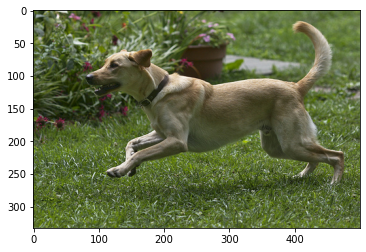

Greedy: a dog is running through the grass
Beam Search, K = 3: a brown dog is running through the grass 
Beam Search, K = 5: a brown dog is running through the grass 
Beam Search, K = 7: a brown dog is running through the grass 
Beam Search, K = 10: a brown dog is running through the grass 


In [41]:
pic = list(encoding_test.keys())[5]
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

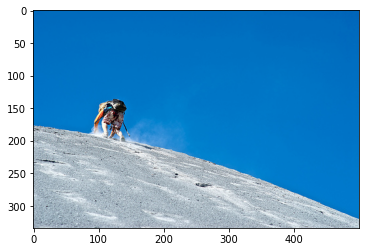

Greedy: a man in a red shirt and red shorts is standing on a snowcapped mountain
Beam Search, K = 3: a man in a red shirt is climbing up a snowy mountain 
Beam Search, K = 5: a man stands on top of a snowcapped mountain 
Beam Search, K = 7: a group of climbers climbing up a snow covered mountain 
Beam Search, K = 10: a group of climbers climbing up a snowy mountain face 


In [43]:
pic = list(encoding_test.keys())[20]
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:", greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

## BLEU Score

In [84]:
def eval_model(encoding_test, test_descriptions, search):
    test_images = list(encoding_test.keys())
    references = []
    hypotheses = []
    
    for img in tqdm(encoding_test.keys()):
        image = encoding_test[img].reshape((1,2048))
        prediction = ""
        
        if search == "greedy":
            prediction = greedySearch(image)
        elif (search == "BeamK3"):
            prediction = beam_search_predictions(image, beam_index = 3)
        elif (search == "BeamK5"):    
            prediction = beam_search_predictions(image, beam_index = 5)
        elif search == "BeamK7":    
            prediction = beam_search_predictions(image, beam_index = 7)
        elif search == "BeamK10":    
            prediction = beam_search_predictions(image, beam_index = 10)
            
        hypotheses.append(prediction.split())
        refs = [caption.split() for caption in test_descriptions[img]]
        references.append(refs)
        
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    print("BLEU-1: {:.4f}".format(bleu_1))
    print("BLEU-2: {:.4f}".format(bleu_2))
    print("BLEU-3: {:.4f}".format(bleu_3))
    print("BLEU-4: {:.4f}".format(bleu_4))

### Greedy Search

In [85]:
eval_model(encoding_test, test_descriptions, "greedy")

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.5064
BLEU-2: 0.3275
BLEU-3: 0.2029
BLEU-4: 0.1231


### Beam Search, K = 3

In [ ]:
eval_model(encoding_test, test_descriptions, "BeamK3")

  0%|          | 0/1000 [00:00<?, ?it/s]

### Beam Search, K = 5

In [ ]:
eval_model(encoding_test, test_descriptions, "BeamK5")

### Beam Search, K = 7

In [ ]:
eval_model(encoding_test, test_descriptions, "BeamK7")

### Beam Search, K = 10

In [ ]:
eval_model(encoding_test, test_descriptions, "BeamK10")